In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

## Dataset Loading and Dataset Preparation

In [2]:
path='/kaggle/input/final-data/Final_data.csv'

In [3]:
df=pd.read_csv(path)
ts=df['Total Demand (as recorded)']
ts

0         2664.281900
1         2698.868767
2         2710.682853
3         2696.470040
4         2666.727600
             ...     
262747    5136.024902
262748    5165.746387
262749    5104.936882
262750    5071.101107
262751    4985.896029
Name: Total Demand (as recorded), Length: 262752, dtype: float64

In [4]:
ts_diff1 = ts.dropna()
ts_diff1

0         2664.281900
1         2698.868767
2         2710.682853
3         2696.470040
4         2666.727600
             ...     
262747    5136.024902
262748    5165.746387
262749    5104.936882
262750    5071.101107
262751    4985.896029
Name: Total Demand (as recorded), Length: 262752, dtype: float64

In [5]:
ts_diff1 = ts.dropna()
ts_diff1_array = ts_diff1.values.reshape(-1, 1)
len(ts_diff1_array)

262752

In [6]:
import numpy as np

def create_sequences(data, past_window, future_window):
    X, y = [], []
    for i in range(len(data) - past_window - future_window):
        X.append(data[i:i + past_window])
        y.append(data[i + past_window:i + past_window + future_window]) 
    return np.array(X), np.array(y)
past_window = 7 * 96 
future_window = 96
X, y = create_sequences(ts_diff1_array, past_window, future_window)
print("Shape of X:", X.shape) 
print("Shape of y:", y.shape)  

Shape of X: (261984, 672, 1)
Shape of y: (261984, 96, 1)


In [7]:
train_size = int(0.7 * len(X))  # 70% train
val_size = int(0.2 * len(X))   # 15% validation
test_size = len(X) - train_size - val_size  # Remaining 15% for test

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
# Scale data

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (183388, 672, 1) (183388, 96, 1)
Validation: (52396, 672, 1) (52396, 96, 1)
Test: (26200, 672, 1) (26200, 96, 1)


In [8]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)

# Transform validation and test data using the same scaler (DO NOT FIT AGAIN)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, y_val.shape[-1])).reshape(y_val.shape)

X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)


## LSTM with Attention(Past window=One week(672 timestamps) and Future Window=168 timestamps)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class Encoder(nn.Module):
    def __init__(self, input_size, encoder_num_hidden, T):
        super(Encoder, self).__init__()
        self.T = T
        self.encoder_num_hidden = encoder_num_hidden
        self.lstm_layer = nn.LSTM(input_size=input_size,
                                  hidden_size=encoder_num_hidden,
                                  batch_first=True)

    def forward(self, X):
        _, (h_n, c_n) = self.lstm_layer(X)
        return h_n, c_n

class Decoder(nn.Module):
    def __init__(self, T, decoder_num_hidden, encoder_num_hidden, output_size):
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T
        self.output_size = output_size  # Now set to 168

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )

        self.lstm_layer = nn.LSTM(
            input_size=encoder_num_hidden + 1,
            hidden_size=decoder_num_hidden,
            batch_first=True
        )

        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, output_size)

    def forward(self, X_encoded, y_prev):
        batch_size = X_encoded.shape[0]
        d_n = torch.zeros(1, batch_size, self.decoder_num_hidden).to(X_encoded.device)
        c_n = torch.zeros(1, batch_size, self.decoder_num_hidden).to(X_encoded.device)

        for t in range(y_prev.shape[1]):
            x = torch.cat((d_n.repeat(X_encoded.shape[1], 1, 1).permute(1, 0, 2),
                           c_n.repeat(X_encoded.shape[1], 1, 1).permute(1, 0, 2),
                           X_encoded), dim=2)

            seq_len = X_encoded.shape[1]
            beta = torch.softmax(
                self.attn_layer(x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, seq_len),
                dim=1)

            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]

            if t < self.T - 1:
                y_tilde = torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1)
                self.lstm_layer.flatten_parameters()
                _, (d_n, c_n) = self.lstm_layer(y_tilde.unsqueeze(1), (d_n, c_n))

        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))
        return y_pred

class DA_rnn(nn.Module):
    def __init__(self, X, y, X_val, y_val, X_test, y_test, T, encoder_num_hidden, decoder_num_hidden, batch_size, learning_rate, epochs, scaler_X, scaler_y):
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.T = T

        self.X, self.y = X, y
        self.X_val, self.y_val = X_val, y_val
        self.X_test, self.y_test = X_test, y_test
        self.output_size = y.shape[1]  # Should be 168

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.Encoder = Encoder(input_size=X.shape[2],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)

        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T,
                               output_size=self.output_size).to(self.device)

        self.encoder_optimizer = optim.Adam(self.Encoder.parameters(), lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(self.Decoder.parameters(), lr=self.learning_rate)
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y

    def mse_loss(self, y_pred, y_true):
        return torch.mean((y_true - y_pred) ** 2)

    def mean_absolute_percentage_error(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    
    def evaluate(self, X_val, y_val, scaler):
        self.Encoder.eval()
        self.Decoder.eval()
    
        all_preds = []
        all_actuals = []
    
        with torch.no_grad():
            idx = 0
            total_loss = 0
            iter_count = int(np.ceil(X_val.shape[0] / self.batch_size))
    
            while idx < X_val.shape[0]:
                indices = np.arange(idx, min(idx + self.batch_size, X_val.shape[0]))
    
                x_batch = torch.tensor(X_val[indices], dtype=torch.float32).to(self.device)
                y_batch = torch.tensor(y_val[indices], dtype=torch.float32).to(self.device)
    
                h_n, c_n = self.Encoder(x_batch)
                y_pred = self.Decoder(h_n.permute(1, 0, 2), y_batch[:, :-1, 0])
    
                # Use only last 96 values from predicted and actual for loss
                loss = self.mse_loss(y_pred[:, -96:], y_batch[:, -96:, 0])
                total_loss += loss.item()
    
                all_preds.append(y_pred[:, -96:].cpu().numpy())
                all_actuals.append(y_batch[:, -96:, 0].cpu().numpy())
    
                idx += self.batch_size
    
        y_pred_np = np.concatenate(all_preds).flatten()
        y_actual_np = np.concatenate(all_actuals).flatten()
    
        y_pred_np = scaler.inverse_transform(y_pred_np.reshape(-1, 1)).flatten()
        y_actual_np = scaler.inverse_transform(y_actual_np.reshape(-1, 1)).flatten()
    
        y_pred_np = y_pred_np[:600]
        y_actual_np = y_actual_np[:600]
    
        mape = np.mean(np.abs((y_actual_np - y_pred_np) / y_actual_np)) * 100
        print(f"MAPE Loss: {mape:.2f}%")
    
        plt.figure(figsize=(12, 5))
        plt.plot(y_actual_np, label="Actual", color="blue", alpha=0.7)
        plt.plot(y_pred_np, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.title("Predicted vs Actual (First 600 Points) - Inverse Scaled")
        plt.legend()
        plt.show()
    
        return total_loss / iter_count

    def train(self):
        iter_per_epoch = int(np.ceil(self.X.shape[0] / self.batch_size))
        self.epoch_losses = np.zeros(self.epochs)
        min_val_loss = float('inf')
    
        for epoch in range(self.epochs):
            idx = 0
            epoch_loss = 0
    
            self.Encoder.train()
            self.Decoder.train()
    
            while idx < self.X.shape[0]:
                indices = np.arange(idx, min(idx + self.batch_size, self.X.shape[0]))
    
                x_batch = torch.tensor(self.X[indices], dtype=torch.float32).to(self.device)
                y_batch = torch.tensor(self.y[indices], dtype=torch.float32).to(self.device)
    
                self.encoder_optimizer.zero_grad()
                self.decoder_optimizer.zero_grad()
    
                h_n, c_n = self.Encoder(x_batch)
                y_pred = self.Decoder(h_n.permute(1, 0, 2), y_batch[:, :-1, 0])
    
                loss = self.mse_loss(y_pred[:, -96:], y_batch[:, -96:, 0])
    
                loss.backward()
                self.encoder_optimizer.step()
                self.decoder_optimizer.step()
    
                epoch_loss += loss.item()
                idx += self.batch_size
    
            avg_epoch_loss = epoch_loss / iter_per_epoch
            self.epoch_losses[epoch] = avg_epoch_loss
    
            val_loss = self.evaluate(self.X_val, self.y_val, self.scaler_y)
    
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                torch.save(self.state_dict(), '/kaggle/working/best_model.pth')
                print(f"Epoch {epoch}: New best model saved with validation loss {min_val_loss:.4f}")
    
            if epoch % 2 == 0:
                print(f"Epoch {epoch}/{self.epochs}, Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
    def test(self):
        self.Encoder.eval()
        self.Decoder.eval()
    
        all_preds = []
        all_actuals = []
    
        with torch.no_grad():
            idx = 0
    
            while idx < self.X_test.shape[0]:
                indices = np.arange(idx, min(idx + self.batch_size, self.X_test.shape[0]))
    
                x_batch = torch.tensor(self.X_test[indices], dtype=torch.float32).to(self.device)
                y_batch = torch.tensor(self.y_test[indices], dtype=torch.float32).to(self.device)
    
                h_n, c_n = self.Encoder(x_batch)
                y_pred = self.Decoder(h_n.permute(1, 0, 2), y_batch[:, :-1, 0])
    
                all_preds.append(y_pred[:, -96:].cpu())
                all_actuals.append(y_batch[:, -96:, 0].cpu())
    
                idx += self.batch_size
    
        all_preds_tensor = torch.cat(all_preds, dim=0)
        all_actuals_tensor = torch.cat(all_actuals, dim=0)
    
        total_loss = self.mse_loss(all_preds_tensor, all_actuals_tensor).item()
    
        y_pred_np = all_preds_tensor.numpy().flatten()
        y_actual_np = all_actuals_tensor.numpy().flatten()
    
        y_pred_np = self.scaler_y.inverse_transform(y_pred_np.reshape(-1, 1)).flatten()
        y_actual_np = self.scaler_y.inverse_transform(y_actual_np.reshape(-1, 1)).flatten()
    
        mape = np.mean(np.abs((y_actual_np - y_pred_np) / y_actual_np)) * 100
        print(f"MAPE Loss: {mape :.2f}%")
        print(y_pred_np.shape)
        print(y_actual_np.shape)
    
        plt.figure(figsize=(15, 10))
        plt.plot(y_actual_np[:1000], label="Actual", color="blue", alpha=0.7)
        plt.plot(y_pred_np[:1000], label="Predicted", color="red", linestyle="dashed", alpha=0.7)
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.title("Predicted vs Actual (All Points) - Inverse Scaled")
        plt.legend()
        plt.show()
    
        print(total_loss)
        print(y_pred_np.shape)
        print(y_actual_np.shape)
        
        
    
num_samples = 183388
T = 672  # Input sequence length
future_steps = 168  # Prediction steps

# Convert to tensors (if needed)
X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

# Initialize the DA-RNN model
model = DA_rnn(
    X_train_scaled, y_train_scaled,
    X_val_scaled, y_val_scaled,
    X_test_scaled, y_test_scaled,
    T=T,
    encoder_num_hidden=64,
    decoder_num_hidden=64,
    batch_size=128,
    learning_rate=0.001,
    epochs=50,
    scaler_X=scaler_X,
    scaler_y=scaler_y
)
model.load_state_dict(torch.load("/kaggle/input/best_model_168/pytorch/default/1/best_model_168.pth"))

<ipython-input-26-d7a357613a16>:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/input/best_model_168/pytorch/default/1/best_mode

<All keys matched successfully>

MAPE Loss: 3.87%
(2515200,)
(2515200,)


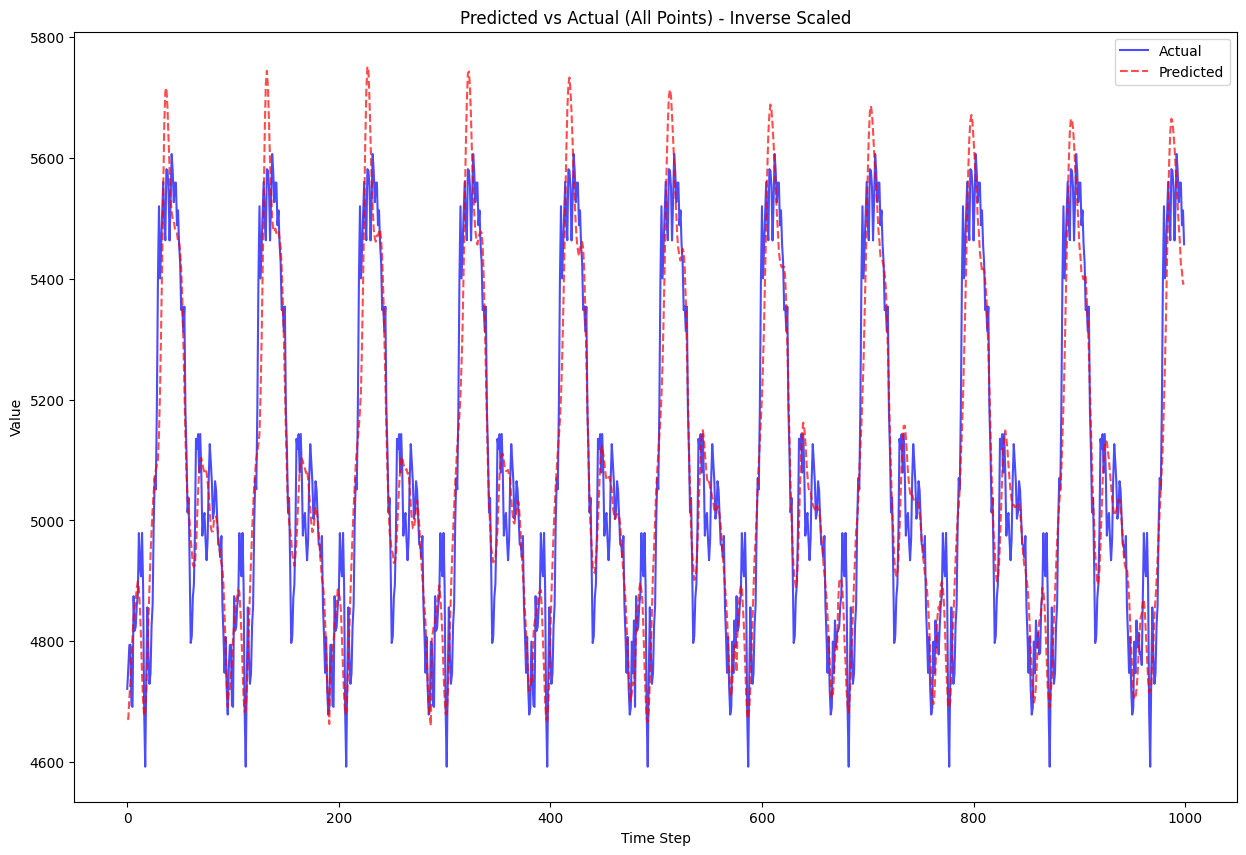

0.00030105363111943007
(2515200,)
(2515200,)


In [27]:
model.test()

## LSTM with Attention(Past window=One week(672 timestamps) and Future Window=96 timestamps)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class Encoder(nn.Module):
    """Encoder for DA-RNN"""
    def __init__(self, input_size, encoder_num_hidden, T):
        super(Encoder, self).__init__()
        self.T = T
        self.encoder_num_hidden = encoder_num_hidden

        self.lstm_layer = nn.LSTM(input_size=input_size,
                                  hidden_size=encoder_num_hidden,
                                  batch_first=True)

    def forward(self, X):
        # X shape: (batch_size, T, features)
        _, (h_n, c_n) = self.lstm_layer(X)
        return h_n, c_n

class Decoder(nn.Module):
    """Decoder for DA-RNN"""
    def __init__(self, T, decoder_num_hidden, encoder_num_hidden, output_size):
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T
        self.output_size = output_size  # Number of future steps to predict (96)

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )

        self.lstm_layer = nn.LSTM(
                            input_size=encoder_num_hidden + 1,  # Fix the input size
                            hidden_size=decoder_num_hidden,
                            batch_first=True
                        )


        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, output_size)

    def forward(self, X_encoded, y_prev):
        batch_size = X_encoded.shape[0]

        d_n = torch.zeros(1, batch_size, self.decoder_num_hidden).to(X_encoded.device)
        c_n = torch.zeros(1, batch_size, self.decoder_num_hidden).to(X_encoded.device)

        for t in range(y_prev.shape[1]):  # Ensure valid indexing

            x = torch.cat((d_n.repeat(X_encoded.shape[1], 1, 1).permute(1, 0, 2),
                   c_n.repeat(X_encoded.shape[1], 1, 1).permute(1, 0, 2),
                   X_encoded), dim=2)

            seq_len = X_encoded.shape[1]  # Ensure sequence length is correct
            beta = F.softmax(self.attn_layer(x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, seq_len), dim=1)


            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]

            if t < self.T - 1:
                y_tilde = torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1)
                self.lstm_layer.flatten_parameters()
                _, (d_n, c_n) = self.lstm_layer(y_tilde.unsqueeze(1), (d_n, c_n))

        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))
        return y_pred

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class DA_rnn(nn.Module):
    """DA-RNN model"""
    def __init__(self, X, y, X_val, y_val, X_test, y_test, T, encoder_num_hidden, decoder_num_hidden, batch_size, learning_rate, epochs,scaler_X,scaler_y):
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.T = T
        
        # Store dataset
        self.X, self.y = X, y  # Training Data
        self.X_val, self.y_val = X_val, y_val  # Validation Data
        self.X_test, self.y_test = X_test, y_test  # Test Data
        self.output_size = y.shape[1]  # 96 time steps

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.Encoder = Encoder(input_size=X.shape[2],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)

        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T,
                               output_size=self.output_size).to(self.device)

        self.encoder_optimizer = optim.Adam(self.Encoder.parameters(), lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(self.Decoder.parameters(), lr=self.learning_rate)
        self.scaler_X= scaler_X
        self.scaler_y = scaler_y

    def mse_loss(self, y_pred, y_true):
        return torch.mean((y_true - y_pred) ** 2)
    def mean_absolute_percentage_error(self,y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    import matplotlib.pyplot as plt

    import matplotlib.pyplot as plt
    import numpy as np
    
    import numpy as np
    
    def evaluate(self, X_val, y_val, scaler):
        """Compute validation loss without updating weights, apply inverse scaling, and plot the first 600 points"""
        self.Encoder.eval()
        self.Decoder.eval()
    
        all_preds = []
        all_actuals = []
    
        with torch.no_grad():
            idx = 0
            total_loss = 0
            iter_count = int(np.ceil(X_val.shape[0] / self.batch_size))
    
            while idx < X_val.shape[0]:
                indices = np.arange(idx, min(idx + self.batch_size, X_val.shape[0]))
    
                # Convert NumPy arrays to tensors
                x_batch = torch.tensor(X_val[indices], dtype=torch.float32).to(self.device)
                y_batch = torch.tensor(y_val[indices], dtype=torch.float32).to(self.device)
    
                h_n, c_n = self.Encoder(x_batch)
                y_pred = self.Decoder(h_n.permute(1, 0, 2), y_batch[:, :-1, 0])
    
                loss = self.mse_loss(y_pred, y_batch[:, -96:, 0])
                total_loss += loss.item()
    
                # Store values for inverse scaling & plotting
                all_preds.append(y_pred.cpu().numpy())
                all_actuals.append(y_batch[:, -96:, 0].cpu().numpy())
    
                idx += self.batch_size
    
        # Flatten arrays
        y_pred_np = np.concatenate(all_preds).flatten()
        y_actual_np = np.concatenate(all_actuals).flatten()
    
        # Apply inverse scaling
        y_pred_np = scaler.inverse_transform(y_pred_np.reshape(-1, 1)).flatten()
        y_actual_np = scaler.inverse_transform(y_actual_np.reshape(-1, 1)).flatten()
    
        # Select first 600 points
        y_pred_np = y_pred_np[:600]
        y_actual_np = y_actual_np[:600]
    
        # Compute MAPE loss
        mape = np.mean(np.abs((y_actual_np - y_pred_np) / y_actual_np)) * 100
        print(f"MAPE Loss: {mape:.2f}%")
    
        # Plot results
        plt.figure(figsize=(12, 5))
        plt.plot(y_actual_np, label="Actual", color="blue", alpha=0.7)
        plt.plot(y_pred_np, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
        
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.title("Predicted vs Actual (First 600 Points) - Inverse Scaled")
        plt.legend()
        plt.show()
    
        return total_loss / iter_count




    def train(self):
        iter_per_epoch = int(np.ceil(self.X.shape[0] / self.batch_size))
        self.epoch_losses = np.zeros(self.epochs)
        min_val_loss = float('inf')  # Initialize minimum validation loss

        for epoch in range(self.epochs):
            idx = 0
            epoch_loss = 0

            self.Encoder.train()
            self.Decoder.train()

            while idx < self.X.shape[0]:
                indices = np.arange(idx, min(idx + self.batch_size, self.X.shape[0]))

                # Convert NumPy arrays to tensors
                x_batch = torch.tensor(self.X[indices], dtype=torch.float32).to(self.device)
                y_batch = torch.tensor(self.y[indices], dtype=torch.float32).to(self.device)

                self.encoder_optimizer.zero_grad()
                self.decoder_optimizer.zero_grad()

                h_n, c_n = self.Encoder(x_batch)
                y_pred = self.Decoder(h_n.permute(1, 0, 2), y_batch[:, :-1, 0])

                loss = self.mse_loss(y_pred, y_batch[:, -96:, 0])

                loss.backward()
                self.encoder_optimizer.step()
                self.decoder_optimizer.step()

                epoch_loss += loss.item()
                idx += self.batch_size

            avg_epoch_loss = epoch_loss / iter_per_epoch
            self.epoch_losses[epoch] = avg_epoch_loss

            # Compute validation loss
            val_loss = self.evaluate(self.X_val, self.y_val,self.scaler_y)

            # Save best model based on validation loss
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                torch.save(self.state_dict(), '/kaggle/working/best_model.pth')
                print(f"Epoch {epoch}: New best model saved with validation loss {min_val_loss:.4f}")

            if epoch % 2 == 0:
                print(f"Epoch {epoch}/{self.epochs}, Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    def test(self):
        """Test the model on test data"""
        self.Encoder.eval()
        self.Decoder.eval()
    
        all_preds = []
        all_actuals = []
    
        with torch.no_grad():
            idx = 0
    
            while idx < self.X_test.shape[0]:
                indices = np.arange(idx, min(idx + self.batch_size, X_test.shape[0]))
    
                x_batch = torch.tensor(self.X_test[indices], dtype=torch.float32).to(self.device)
                y_batch = torch.tensor(self.y_test[indices], dtype=torch.float32).to(self.device)
    
                h_n, c_n = self.Encoder(x_batch)
                y_pred = self.Decoder(h_n.permute(1, 0, 2), y_batch[:, :-1, 0])
    
                all_preds.append(y_pred.cpu())
                all_actuals.append(y_batch[:, -96:, 0].cpu())
    
                idx += self.batch_size
    
        # Concatenate all predictions and actuals
        all_preds_tensor = torch.cat(all_preds, dim=0)
        all_actuals_tensor = torch.cat(all_actuals, dim=0)
    
        # Compute loss over all predictions at once
        total_loss = self.mse_loss(all_preds_tensor, all_actuals_tensor).item()
    
        # Convert to NumPy for inverse scaling and plotting
        y_pred_np = all_preds_tensor.numpy().flatten()
        y_actual_np = all_actuals_tensor.numpy().flatten()
    
        y_pred_np = scaler_y.inverse_transform(y_pred_np.reshape(-1, 1)).flatten()
        y_actual_np = scaler_y.inverse_transform(y_actual_np.reshape(-1, 1)).flatten()
    
        # Select first 600 points
        y_pred_np = y_pred_np
        y_actual_np = y_actual_np
        # Compute MAPE loss
        mape = np.mean(np.abs((y_actual_np - y_pred_np) / y_actual_np)) * 100
        print(f"MAPE Loss: {mape :.2f}%")

        print(y_pred_np.shape)
        # Plot results
        plt.figure(figsize=(15, 10))
        plt.plot(y_actual_np[6000:7000], label="Actual", color="blue", alpha=0.7)
        plt.plot(y_pred_np[6000:7000], label="Predicted", color="red", linestyle="dashed", alpha=0.7)
        
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.title("Predicted vs Actual (First 600 Points) - Inverse Scaled")
        plt.legend()
        plt.show()
    
        print(total_loss)



# Define dataset shapes

num_samples = 183388
T = 672 # Input sequence length
future_steps = 96  # Prediction steps

# X = np.random.randn(num_samples, T, 1)  # Shape: (samples, T, features)
# y = np.random.randn(num_samples, future_steps, 1)  # Shape: (samples, future_steps, targets)


X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

model1 = DA_rnn(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled, T=T, encoder_num_hidden=64, decoder_num_hidden=64, batch_size=128, learning_rate=0.001, epochs=50,scaler_X=scaler_X,scaler_y=scaler_y)


# model1.load_state_dict(torch.load("/kaggle/input/model_96/pytorch/default/1/best_model (6722) latest.pth"))

<ipython-input-24-1b0e6a1dbdcc>:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load("/kaggle/input/model_96/pytorch/default/1/best_model (67

<All keys matched successfully>

In [ ]:
model1.test()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class Encoder(nn.Module):
    """Encoder for DA-RNN"""
    def __init__(self, input_size, encoder_num_hidden, T):
        super(Encoder, self).__init__()
        self.T = T
        self.encoder_num_hidden = encoder_num_hidden

        self.lstm_layer = nn.LSTM(input_size=input_size,
                                  hidden_size=encoder_num_hidden,
                                  batch_first=True)

    def forward(self, X):
        # X shape: (batch_size, T, features)
        _, (h_n, c_n) = self.lstm_layer(X)
        return h_n, c_n

class Decoder(nn.Module):
    """Decoder for DA-RNN"""
    def __init__(self, T, decoder_num_hidden, encoder_num_hidden, output_size):
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T
        self.output_size = output_size  # Number of future steps to predict (96)

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )

        self.lstm_layer = nn.LSTM(
                            input_size=encoder_num_hidden + 1,  # Fix the input size
                            hidden_size=decoder_num_hidden,
                            batch_first=True
                        )


        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, output_size)

    def forward(self, X_encoded, y_prev):
        batch_size = X_encoded.shape[0]

        d_n = torch.zeros(1, batch_size, self.decoder_num_hidden).to(X_encoded.device)
        c_n = torch.zeros(1, batch_size, self.decoder_num_hidden).to(X_encoded.device)

        for t in range(y_prev.shape[1]):  # Ensure valid indexing

            x = torch.cat((d_n.repeat(X_encoded.shape[1], 1, 1).permute(1, 0, 2),
                   c_n.repeat(X_encoded.shape[1], 1, 1).permute(1, 0, 2),
                   X_encoded), dim=2)

            seq_len = X_encoded.shape[1]  # Ensure sequence length is correct
            beta = F.softmax(self.attn_layer(x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, seq_len), dim=1)


            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]

            if t < self.T - 1:
                y_tilde = torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1)
                self.lstm_layer.flatten_parameters()
                _, (d_n, c_n) = self.lstm_layer(y_tilde.unsqueeze(1), (d_n, c_n))

        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))
        return y_pred

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class DA_rnn(nn.Module):
    """DA-RNN model"""
    def __init__(self, X, y, X_val, y_val, X_test, y_test, T, encoder_num_hidden, decoder_num_hidden, batch_size, learning_rate, epochs,scaler_X,scaler_y):
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.T = T
        
        # Store dataset
        self.X, self.y = X, y  # Training Data
        self.X_val, self.y_val = X_val, y_val  # Validation Data
        self.X_test, self.y_test = X_test, y_test  # Test Data
        self.output_size = y.shape[1]  # 96 time steps

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.Encoder = Encoder(input_size=X.shape[2],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)

        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T,
                               output_size=self.output_size).to(self.device)

        self.encoder_optimizer = optim.Adam(self.Encoder.parameters(), lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(self.Decoder.parameters(), lr=self.learning_rate)
        self.scaler_X= scaler_X
        self.scaler_y = scaler_y

    def mse_loss(self, y_pred, y_true):
        return torch.mean((y_true - y_pred) ** 2)
    def mean_absolute_percentage_error(self,y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    import matplotlib.pyplot as plt

    import matplotlib.pyplot as plt
    import numpy as np
    
    import numpy as np
    
    def evaluate(self, X_val, y_val, scaler):
        """Compute validation loss without updating weights, apply inverse scaling, and plot the first 600 points"""
        self.Encoder.eval()
        self.Decoder.eval()
    
        all_preds = []
        all_actuals = []
    
        with torch.no_grad():
            idx = 0
            total_loss = 0
            iter_count = int(np.ceil(X_val.shape[0] / self.batch_size))
    
            while idx < X_val.shape[0]:
                indices = np.arange(idx, min(idx + self.batch_size, X_val.shape[0]))
    
                # Convert NumPy arrays to tensors
                x_batch = torch.tensor(X_val[indices], dtype=torch.float32).to(self.device)
                y_batch = torch.tensor(y_val[indices], dtype=torch.float32).to(self.device)
    
                h_n, c_n = self.Encoder(x_batch)
                y_pred = self.Decoder(h_n.permute(1, 0, 2), y_batch[:, :-1, 0])
    
                loss = self.mse_loss(y_pred, y_batch[:, -96:, 0])
                total_loss += loss.item()
    
                # Store values for inverse scaling & plotting
                all_preds.append(y_pred.cpu().numpy())
                all_actuals.append(y_batch[:, -96:, 0].cpu().numpy())
    
                idx += self.batch_size
    
        # Flatten arrays
        y_pred_np = np.concatenate(all_preds).flatten()
        y_actual_np = np.concatenate(all_actuals).flatten()
    
        # Apply inverse scaling
        y_pred_np = scaler.inverse_transform(y_pred_np.reshape(-1, 1)).flatten()
        y_actual_np = scaler.inverse_transform(y_actual_np.reshape(-1, 1)).flatten()
    
        # Select first 600 points
        y_pred_np = y_pred_np[:600]
        y_actual_np = y_actual_np[:600]
    
        # Compute MAPE loss
        mape = np.mean(np.abs((y_actual_np - y_pred_np) / y_actual_np)) * 100
        print(f"MAPE Loss: {mape:.2f}%")
    
        # Plot results
        plt.figure(figsize=(12, 5))
        plt.plot(y_actual_np, label="Actual", color="blue", alpha=0.7)
        plt.plot(y_pred_np, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
        
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.title("Predicted vs Actual (First 600 Points) - Inverse Scaled")
        plt.legend()
        plt.show()
    
        return total_loss / iter_count




    def train(self):
        iter_per_epoch = int(np.ceil(self.X.shape[0] / self.batch_size))
        self.epoch_losses = np.zeros(self.epochs)
        min_val_loss = float('inf')  # Initialize minimum validation loss

        for epoch in range(self.epochs):
            idx = 0
            epoch_loss = 0

            self.Encoder.train()
            self.Decoder.train()

            while idx < self.X.shape[0]:
                indices = np.arange(idx, min(idx + self.batch_size, self.X.shape[0]))

                # Convert NumPy arrays to tensors
                x_batch = torch.tensor(self.X[indices], dtype=torch.float32).to(self.device)
                y_batch = torch.tensor(self.y[indices], dtype=torch.float32).to(self.device)

                self.encoder_optimizer.zero_grad()
                self.decoder_optimizer.zero_grad()

                h_n, c_n = self.Encoder(x_batch)
                y_pred = self.Decoder(h_n.permute(1, 0, 2), y_batch[:, :-1, 0])

                loss = self.mse_loss(y_pred, y_batch[:, -96:, 0])

                loss.backward()
                self.encoder_optimizer.step()
                self.decoder_optimizer.step()

                epoch_loss += loss.item()
                idx += self.batch_size

            avg_epoch_loss = epoch_loss / iter_per_epoch
            self.epoch_losses[epoch] = avg_epoch_loss

            # Compute validation loss
            val_loss = self.evaluate(self.X_val, self.y_val,self.scaler_y)

            # Save best model based on validation loss
            if val_loss < min_val_loss:
                min_val_loss = val_loss
                torch.save(self.state_dict(), '/kaggle/working/best_model.pth')
                print(f"Epoch {epoch}: New best model saved with validation loss {min_val_loss:.4f}")

            if epoch % 2 == 0:
                print(f"Epoch {epoch}/{self.epochs}, Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    def test(self):
        """Test the model on test data"""
        self.Encoder.eval()
        self.Decoder.eval()
    
        all_preds = []
        all_actuals = []
    
        with torch.no_grad():
            idx = 0
    
            while idx < self.X_test.shape[0]:
                indices = np.arange(idx, min(idx + self.batch_size, X_test.shape[0]))
    
                x_batch = torch.tensor(self.X_test[indices], dtype=torch.float32).to(self.device)
                y_batch = torch.tensor(self.y_test[indices], dtype=torch.float32).to(self.device)
    
                h_n, c_n = self.Encoder(x_batch)
                y_pred = self.Decoder(h_n.permute(1, 0, 2), y_batch[:, :-1, 0])
    
                all_preds.append(y_pred.cpu())
                all_actuals.append(y_batch[:, -96:, 0].cpu())
    
                idx += self.batch_size
    
        # Concatenate all predictions and actuals
        all_preds_tensor = torch.cat(all_preds, dim=0)
        all_actuals_tensor = torch.cat(all_actuals, dim=0)
    
        # Compute loss over all predictions at once
        total_loss = self.mse_loss(all_preds_tensor, all_actuals_tensor).item()
    
        # Convert to NumPy for inverse scaling and plotting
        y_pred_np = all_preds_tensor.numpy().flatten()
        y_actual_np = all_actuals_tensor.numpy().flatten()
    
        y_pred_np = scaler_y.inverse_transform(y_pred_np.reshape(-1, 1)).flatten()
        y_actual_np = scaler_y.inverse_transform(y_actual_np.reshape(-1, 1)).flatten()
    
        # Select first 600 points
        y_pred_np = y_pred_np
        y_actual_np = y_actual_np
        # Compute MAPE loss
        mape = np.mean(np.abs((y_actual_np - y_pred_np) / y_actual_np)) * 100
        print(f"MAPE Loss: {mape * 4:.2f}%")

        print(y_pred_np.shape)
        # Plot results
        plt.figure(figsize=(15, 10))
        plt.plot(y_actual_np[6000:7000], label="Actual", color="blue", alpha=0.7)
        plt.plot(y_pred_np[6000:7000], label="Predicted", color="red", linestyle="dashed", alpha=0.7)
        
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.title("Predicted vs Actual (First 600 Points) - Inverse Scaled")
        plt.legend()
        plt.show()
    
        print(total_loss)



# Define dataset shapes

num_samples = 183388
T = 96 # Input sequence length
future_steps = 168  # Prediction steps



X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

model = DA_rnn(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled, T=T, encoder_num_hidden=64, decoder_num_hidden=64, batch_size=128, learning_rate=0.001, epochs=50,scaler_X=scaler_X,scaler_y=scaler_y)



In [ ]:
model.test()

## Basic LSTM Model

In [ ]:
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=3, batch_first=True, dropout=0.2)

        self.fc_layers = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 168)  # Predict 168 future time steps
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)              # x: (batch_size, 672, 1)
        last_output = lstm_out[:, -1, :]        # Take last time step's output: (batch_size, 256)
        out = self.fc_layers(last_output)       # Pass through dense layers
        return out                              # Output: (batch_size, 168)

# Instantiate and set up
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



## Basic  GRU Model

In [ ]:
import torch.nn as nn
import torch.optim as optim

class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=256, num_layers=3, batch_first=True, dropout=0.2)

        self.fc_layers = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 168)  # Predict 168 future time steps
        )

    def forward(self, x):
        gru_out, _ = self.gru(x)                # x: (batch_size, 672, 1)
        last_output = gru_out[:, -1, :]         # Take last time step's output: (batch_size, 256)
        out = self.fc_layers(last_output)       # Pass through dense layers
        return out                              # Output: (batch_size, 168)

# Instantiate and set up
model = GRUModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def evaluate_model(model, X_data_scaled, y_data_scaled, scaler_y, device, batch_size=128, plot_title=None):
    model.eval()
    all_preds, all_actuals = [], []
    
    with torch.no_grad():
        idx = 0
        while idx < X_data_scaled.shape[0]:
            end_idx = min(idx + batch_size, X_data_scaled.shape[0])

            X_batch = torch.tensor(X_data_scaled[idx:end_idx], dtype=torch.float32).to(device)
            y_batch = torch.tensor(y_data_scaled[idx:end_idx], dtype=torch.float32).to(device).squeeze(-1)

            y_pred_scaled = model(X_batch)  # shape: (B, 168)

            # Inverse scale last 96 timesteps
            y_pred_np = y_pred_scaled[:, -96:].cpu().numpy().reshape(-1, 1)
            y_true_np = y_batch[:, -96:].cpu().numpy().reshape(-1, 1)

            y_pred_inv = scaler_y.inverse_transform(y_pred_np)
            y_true_inv = scaler_y.inverse_transform(y_true_np)

            all_preds.append(y_pred_inv)
            all_actuals.append(y_true_inv)

            # MSE on inverse-scaled data
            loss = np.mean((y_pred_inv - y_true_inv) ** 2)
            idx += batch_size

    all_preds = np.concatenate(all_preds).flatten()
    all_actuals = np.concatenate(all_actuals).flatten()
    avg_loss = np.mean((all_preds - all_actuals) ** 2)

    if plot_title:
        plt.figure(figsize=(14, 6))
        plt.plot(all_actuals, label='Actual', color='blue', alpha=0.7)
        plt.plot(all_preds, label='Predicted', color='red', linestyle='--', alpha=0.7)
        plt.title(plot_title)
        plt.xlabel("Time Step")
        plt.ylabel("Target Value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return avg_loss


def train_model(model, X_train_scaled, y_train_scaled, 
                X_val_scaled, y_val_scaled,
                scaler_y, optimizer, device, epochs=20, batch_size=128):
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        all_preds, all_actuals = [], []

        idx = 0
        while idx < X_train_scaled.shape[0]:
            end_idx = min(idx + batch_size, X_train_scaled.shape[0])
            X_batch = torch.tensor(X_train_scaled[idx:end_idx], dtype=torch.float32).to(device)
            y_batch = torch.tensor(y_train_scaled[idx:end_idx], dtype=torch.float32).to(device).squeeze(-1)

            optimizer.zero_grad()
            y_pred_scaled = model(X_batch)

            # Inverse transform for loss computation
            y_pred_np = y_pred_scaled[:, -96:].detach().cpu().numpy().reshape(-1, 1)
            y_true_np = y_batch[:, -96:].detach().cpu().numpy().reshape(-1, 1)

            y_pred_inv = scaler_y.inverse_transform(y_pred_np)
            y_true_inv = scaler_y.inverse_transform(y_true_np)

            loss_val = np.mean((y_pred_inv - y_true_inv) ** 2)
            loss = torch.tensor(loss_val, requires_grad=True, device=device)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            idx += batch_size

        avg_train_loss = train_loss / (X_train_scaled.shape[0] // batch_size)

        # Evaluate and plot
        avg_val_loss = evaluate_model(
            model, X_val_scaled, y_val_scaled, scaler_y, device,
            batch_size, plot_title=f"Epoch {epoch+1}: Predicted vs Actual (Inverse Scaled)"
        )

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


def test_model(model, X_test_scaled, y_test_scaled, scaler_y, device, batch_size=128):
    test_loss = evaluate_model(
        model, X_test_scaled, y_test_scaled, scaler_y, device,
        batch_size, plot_title="Test Prediction vs Actual (Inverse Scaled)"
    )
    print(f"Test Loss (MSE on inverse-scaled): {test_loss:.4f}")



In [ ]:
train_model(model, X_train_scaled, y_train_scaled,
            X_val_scaled, y_val_scaled,
            scaler_y, optimizer, device,
            epochs=20, batch_size=128)

test_model(model, X_test_scaled, y_test_scaled, scaler_y, device)
